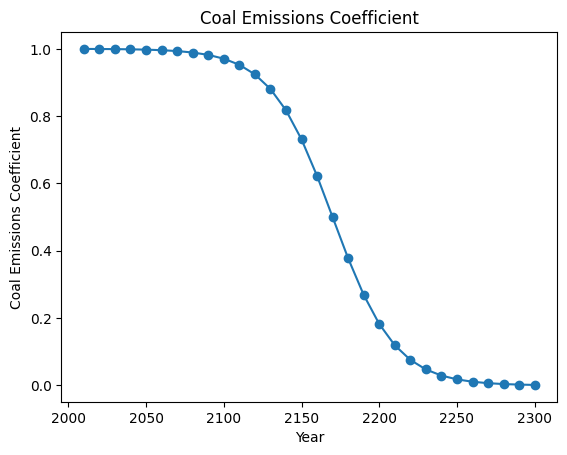

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#########################################
###      Section 1: Parameters        ###
#########################################

# Time
T = 30  # Number of direct optimization periods T
y = np.zeros(T, dtype=int)  # Corresponding calendar years
y[0] = 2010
for i in range(1, T):
    y[i] = 2010 + i * 10

n = 100  # Number of pre-balanced growth path simulation periods after T
y2 = np.zeros(T + n, dtype=int)  # Corresponding calendar years
y2[0] = 2010
for i in range(1, T + n):
    y2[i] = 2010 + i * 10

# Climate and Damages
phi = 0.0228
phiL = 0.2
phi0 = 0.393
Sbar = 581         # GtC
S1_2000 = 103      # GtC
S2_2000 = 699      # GtC
gamma = np.full((T,), 0.000023793)

# Energy Aggregation
rho = -0.058
kappa1 = 0.5429
kappa2 = 0.1015
kappa3 = 1 - kappa1 - kappa2  # Ensures sum = 1

# Consistency check
if not np.isclose(kappa1 + kappa2 + kappa3, 1.0):
    print("⚠️ Warning: kappa1 + kappa2 + kappa3 does not sum to 1.")

# Final Goods Production
N = 1                      # Normalize population
alpha = 0.3                # Capital output share
v = 0.04                   # Energy output share
Y2009 = 70000              # Base year annual GDP in billions of USD
r2009 = 0.05               # Base year annual net rate of return
r2009d = ((1 + r2009) ** 10) - 1  # Base year decadal net rate of return

### Depreciation OPTION 1: delta = 100%
delta = 1
Delta = 1 - (1 - delta) ** 10
K0 = (alpha * Y2009 * 10) / (r2009d + Delta)

### Depreciation OPTION 2: delta = 65%, no recalibration
# delta = 0.1
# Delta = 1 - (1 - delta) ** 10
# Delta1 = 1
# K0 = (alpha * Y2009 * 10) / (r2009d + Delta1)

### Depreciation OPTION 3: delta = 65%, with recalibration
# delta = 0.1
# Delta = 1 - (1 - delta) ** 10
# K0 = (alpha * Y2009 * 10) / (r2009d + Delta)

pi00 = 1  # Base period share of labor devoted to final goods production

# Emissions (2008)
E1_2008 = 3.43 + 1.68
E2_2008 = 3.75
E3_2008 = 1.95
E0_2008 = (kappa1 * E1_2008 ** rho + kappa2 * E2_2008 ** rho + kappa3 * E3_2008 ** rho) ** (1 / rho)
E0 = E0_2008 * 10  # GtC per decade

# Initial TFP based on Decadal production function
A0 = (Y2009 * 10) / (
    np.exp(-gamma[0] * ((S1_2000 + S2_2000) - Sbar)) *
    (K0 ** alpha) * ((N * pi00) ** (1 - alpha - v)) * (E0 ** v)
)

### Productivity Growth Rates

# Energy Sector
gZa_en = 0.02  # Annual labor productivity growth rate (energy sectors)
gZ_en = ((1 + gZa_en) ** 10) - 1  # Decadal labor productivity growth rate (energy sectors)

### Final Goods Sector OPTION 1: Specify Labor Productivity Growth
# gZa_y = 0.02
# gAa_y = (1 + gZa_y) ** (1 - alpha - v)
# gZd_y = np.ones(T + n) * (((1 + gZa_y) ** 10) - 1)

### Final Goods Sector OPTION 2: Specify TFP Growth
gAa_y = 0  # Alternative Annual TFP growth rate
gZa_y = (1 + gAa_y) ** (1 / (1 - alpha - v)) - 1
gAd_y = (1 + gAa_y) ** 10 - 1
gZd_y = np.ones(T + n) * (((1 + gZa_y) ** 10) - 1)

### Final Goods Sector OPTION 3: DICE Model TFP Growth
# gANH0 = 0.160023196685654
# gammaNH0 = 0.00942588385340332
# gammaNH1 = 0.00192375245926376
# gANH_y = np.zeros(T)
# for i in range(T):
#     gANH_y[i] = gANH0 * np.exp(-gammaNH0 * 10 * (i+1)) * np.exp(-gammaNH1 * 10 * (i+1))
# gANH_y = np.append(gANH_y, np.full(n, gANH_y[-1]))
# gANHa = np.zeros(T + n)
# gZd_y = np.zeros(T + n)
# for i in range(T + n):
#     gZd_y[i] = ((1 + gANH_y[i]) ** (1 / (1 - alpha - v))) - 1
#     gANHa[i] = ((1 + gANH_y[i]) ** (1 / 10)) - 1
# z = 35
# plt.plot(y2[:z], gANHa[:z] * 100)
# plt.xlabel("Year")
# plt.ylabel("gTFP in Percent per Year")
# plt.title("2010-DICE Model Annual TFP Growth")
# plt.show()

# Final Good Sector TFP Levels
At = np.zeros(T)
At[0] = A0
for i in range(1, T):
    At[i] = At[i - 1] * (1 + gZd_y[i - 1]) ** (1 - alpha - v)

# Long-run Output Growth Rate on BGP
gZBGP = gZd_y[T - 1]
# gZBGP = gZ_en  # Alternative: use energy sector growth rate

# Utility
# sigma = 0.5
sigma = 1  # Logarithmic preferences
# sigma = 1.5
# sigma = 2

### Beta OPTION 1: Specify exogenously
beta = 0.985 ** 10
# beta = 0.999 ** 10

### Beta OPTION 2: Calibrate to maintain effective discount factor = .985
# beta_hat = (0.985 ** 10) / ((1 + gZd_y[0]) ** (1 - sigma))
# beta = beta_hat

# Coal production
A2t = np.zeros(T)
A2t[0] = 7693
for i in range(1, T):
    A2t[i] = A2t[i - 1] * (1 + gZ_en)

# Coal Emissions
ypsilon = np.zeros(T + n)
a_yps = 8
b_yps = -0.05
for i in range(T + n):
    ypsilon[i] = 1 / (1 + np.exp(-(a_yps + b_yps * i * 10)))

#Plot if needed
plt.plot(y, ypsilon[:T], '-o')
plt.xlabel("Year")
plt.ylabel("Coal Emissions Coefficient")
plt.title("Coal Emissions Coefficient")
plt.show()

# Wind production
A3t = np.zeros(T)
A3t[0] = 1311
for i in range(1, T):
    A3t[i] = A3t[i - 1] * (1 + gZ_en)

# Oil
R0 = 253.8  # GtC



In [2]:
def print_parameters():
    print("======= MODEL PARAMETERS VERIFICATION =======")
    print(f"T = {T} | n = {n}")
    print(f"Years y = {y.tolist()}")
    print(f"Years y2 = {y2.tolist()}")
    print(f"phi = {phi}, phiL = {phiL}, phi0 = {phi0}, Sbar = {Sbar}")
    print(f"S1_2000 = {S1_2000}, S2_2000 = {S2_2000}")
    print(f"gamma = {gamma}")
    print(f"rho = {rho}, kappa1 = {kappa1}, kappa2 = {kappa2}, kappa3 = {kappa3}")
    print(f"N = {N}, alpha = {alpha}, v = {v}")
    print(f"Y2009 = {Y2009}, r2009 = {r2009}, r2009d = {r2009d}")
    print(f"delta = {delta}, Delta = {Delta}, K0 = {K0}")
    print(f"pi00 = {pi00}")
    print(f"E0_2008 = {E0_2008}, E0 = {E0}")
    print(f"A0 = {A0}")
    print(f"gZa_en = {gZa_en}, gZ_en = {gZ_en}")
    print(f"gAa_y = {gAa_y}, gZa_y = {gZa_y}, gAd_y = {gAd_y}")
    print(f"gZd_y[0:10] = {gZd_y[:10]}")
    print(f"At[0:10] = {At[:10]}")
    print(f"gZBGP = {gZBGP}")
    print(f"sigma = {sigma}, beta = {beta}")
    print(f"A2t[0:10] = {A2t[:10]}")
    print(f"ypsilon[0:10] = {ypsilon[:10]}")
    print(f"A3t[0:10] = {A3t[:10]}")
    print(f"R0 = {R0}")
    print("=============================================")

print_parameters()


======= MODEL PARAMETERS VERIFICATION =======
T = 30 | n = 100
Years y = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200, 2210, 2220, 2230, 2240, 2250, 2260, 2270, 2280, 2290, 2300]
Years y2 = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200, 2210, 2220, 2230, 2240, 2250, 2260, 2270, 2280, 2290, 2300, 2310, 2320, 2330, 2340, 2350, 2360, 2370, 2380, 2390, 2400, 2410, 2420, 2430, 2440, 2450, 2460, 2470, 2480, 2490, 2500, 2510, 2520, 2530, 2540, 2550, 2560, 2570, 2580, 2590, 2600, 2610, 2620, 2630, 2640, 2650, 2660, 2670, 2680, 2690, 2700, 2710, 2720, 2730, 2740, 2750, 2760, 2770, 2780, 2790, 2800, 2810, 2820, 2830, 2840, 2850, 2860, 2870, 2880, 2890, 2900, 2910, 2920, 2930, 2940, 2950, 2960, 2970, 2980, 2990, 3000, 3010, 3020, 3030, 3040, 3050, 3060, 3070, 3080, 3090, 3100, 3110, 3120, 3130, 3140, 3150, 3160, 3170, 3180, 3190, 3200, 3210, 3220, 32

In [3]:
###### Importing previous results and saving as npy

#from scipy.io import loadmat

#mat_data = loadmat("x_sig1_g0_b985_d1.mat")  # Load the .mat file
#print(mat_data.keys()) # Checking what variables are inside

#x = mat_data['x'].flatten()  # Get the variable x, and flatten to 1D array
#x0 = x # Use for initial guess
#np.save("x_sig1_g0_b985_d1.npy", x0) # Save

##### Loading previously saved npy file
x0 = np.load("x_sig1_g0_b985_d1.npy")
print(x0.shape)


(118,)


In [4]:
########### Define Objective Function ##################
import numpy as np

def GHKT_Objective(x, A2t, A3t, At, Delta, K0, N, R0, S1_2000, S2_2000, Sbar, T,
                   alpha, beta, gZ_en, gZd_y, gZBGP, gamma, kappa1, kappa2, kappa3,
                   phi, phi0, phiL, rho, sigma, v, ypsilon):

    # Oil extraction calculations
    oil = np.zeros(T)
    oil[0] = R0 - x[T-1]
    for i in range(1, T-1):
        oil[i] = x[T + i - 2] - x[T + i - 1]

    ex_Oil = (x[2*T - 3] - x[2*T - 2]) / x[2*T - 3]
    oil[T-1] = x[2*T - 2] * ex_Oil

    ex_rates = np.zeros(T-1)
    for i in range(T-1):
        ex_rates[i] = oil[i] / x[T + i - 1]
    
    # Rest
    coal = np.array([x[2*(T-1) + i] * A2t[i] * N for i in range(T)])
    wind = np.array([x[2*(T-1) + T + i] * A3t[i] * N for i in range(T)])
    energy = np.array([
        (kappa1 * oil[i]**rho + kappa2 * coal[i]**rho + kappa3 * wind[i]**rho)**(1/rho)
        for i in range(T)
    ])
    
    emiss = oil + ypsilon[:T] * coal

    S1t = np.zeros(T)
    S2t_Sbar = np.zeros(T)
    St = np.zeros(T)

    S1t[0] = S1_2000 + phiL * emiss[0]
    S2t_Sbar[0] = (1 - phi) * (S2_2000 - Sbar) + phi0 * (1 - phiL) * emiss[0]
    St[0] = Sbar + S1t[0] + S2t_Sbar[0]

    for i in range(1, T):
        S1t[i] = S1t[i - 1] + phiL * emiss[i]
        S2t_Sbar[i] = (1 - phi) * S2t_Sbar[i - 1] + phi0 * (1 - phiL) * emiss[i]
        St[i] = Sbar + S1t[i] + S2t_Sbar[i]

    Yt = np.zeros(T + 100)
    Ct = np.zeros(T + 100)
    Kt1 = np.zeros(T + 1)

    Yt[0] = At[0] * np.exp(-gamma[0] * (St[0] - Sbar)) * \
        (K0**alpha) * ((1 - x[2*(T-1)] - x[2*(T-1) + T]) * N)**(1 - alpha - v) * \
        energy[0]**v
    Ct[0] = (1 - x[0]) * Yt[0]
    Kt1[0] = x[0] * Yt[0] + (1 - Delta) * K0

    for i in range(1, T - 1):
        Yt[i] = At[i] * np.exp(-gamma[i] * (St[i] - Sbar)) * \
            (Kt1[i - 1]**alpha) * ((1 - x[2*(T-1) + i] - x[2*(T-1) + T + i]) * N)**(1 - alpha - v) * \
            energy[i]**v
        Kt1[i] = x[i] * Yt[i] + (1 - Delta) * Kt1[i - 1]
        Ct[i] = (1 - x[i]) * Yt[i]

    # Final pre-BGP period
    Yt[T-1] = At[T-1] * np.exp(-gamma[T-1] * (St[T-1] - Sbar)) * \
        (Kt1[T-2]**alpha) * ((1 - x[2*(T-1) + T-1] - x[2*(T-1) + 2*T - 1]) * N)**(1 - alpha - v) * \
        energy[T-1]**v
    theta = x[T - 1]
    Ct[T-1] = Yt[T-1] * (1 - theta)
    Kt1[T] = theta * Yt[T-1] + (1 - Delta) * Kt1[T-2]

    # Step 4: BGP (Balanced Growth Path)
    n = 100
    Ktn = np.zeros(n + 1)
    Ytn = np.zeros(n)
    oiln = np.zeros(n)
    En = np.zeros(n)
    Ktn[0] = Kt1[T]

    for i in range(n):
        At = np.append(At, At[T + i - 1] * (1 + gZd_y[T + i - 1])**(1 - alpha - v))
        oiln[i] = ex_Oil * x[2*(T-1)] * ((1 - ex_Oil)**i)
        En[i] = (kappa1 * oiln[i]**rho + kappa2 * (coal[T-1] * (1 + gZ_en)**i)**rho + kappa3 * (wind[T-1] * (1 + gZ_en)**i)**rho)**(1/rho)
        Ytn[i] = At[T+i] * np.exp(-gamma[T-1] * (St[T-1] - Sbar)) * \
                 (Ktn[i]**alpha) * ((1 - x[2*(T-1) + 2*T - 1] - x[2*(T-1) + T - 1]) * N)**(1 - alpha - v) * \
                 En[i]**v
        Ct[T+i] = (1 - theta) * Ytn[i]
        Ktn[i+1] = theta * Ytn[i] + (1 - Delta) * Ktn[i]
        Yt[T+i] = Ytn[i]

    # Step 5: Utility
    ct = Ct[:T+n] / 1e6
    U = np.zeros(T + n)

    for i in range(T + n - 1):
        if Ct[i] < 0:
            U[i] = -99
        else:
            if sigma != 1:
                U[i] = (beta**i) * ((ct[i]**(1 - sigma) - 1) / (1 - sigma))
            else:
                U[i] = (beta**i) * np.log(ct[i])

    if Ct[T+n-1] < 0:
        Ucont = -99
    else:
        if sigma != 1:
            Ucont = (beta**(T+n-1)) * ((ct[T+n-1]**(1 - sigma) - 1) / (1 - sigma)) * (1 / (1 - beta * (1 + gZBGP)**(1 - sigma)))
        else:
            Ucont = (beta**(T+n-1)) * np.log(ct[T+n-1]) * (1 / (1 - beta * (1 + gZBGP)**(1 - sigma)))

    return -1 * (np.sum(U) + Ucont)



In [ ]:
############ Define Constraints ##############################
import numpy as np

def GHKT_Constraints(x, A2t, A3t, At, Delta, K0, N, R0, S1_2000, S2_2000, Sbar, T,
                     alpha, beta, gZ_en, gZd_y, gZBGP, gamma, kappa1, kappa2, kappa3,
                     phi, phi0, phiL, rho, sigma, v, ypsilon):
    
    # Initialize inequality constraints (positive oil and positive consumption)
    c = np.zeros(2*T + 1)

    # Step 1: Energy Inputs
    oil = np.zeros(T)
    oil[0] = R0 - x[T]

    for i in range(T - 2):
        oil[i + 1] = x[T + i] - x[T + i + 1]

    ex_Oil = (x[T - 1 + T - 2] - x[T - 1 + T - 1]) / x[T - 1 + T - 2]
    oil[T - 1] = x[T - 1 + T - 1] * ex_Oil

    # Positive oil constraint: oil(i) > 0.0001 => -oil(i) + 0.0001 <= 0
    for i in range(T):
        c[T + i] = -1 * (oil[i] - 0.0001)

    # Constraint: ex_Oil <= 1 (i.e., oil left extracted fraction should not exceed 1)
    c[2*T] = ex_Oil - 1

    # Compute coal and wind
    coal = np.array([x[2*(T-1) + i] * (A2t[i] * N) for i in range(T)])
    wind = np.array([x[2*(T-1) + T + i] * (A3t[i] * N) for i in range(T)])

    # Total energy
    energy = np.array([
        (kappa1 * oil[i]**rho + kappa2 * coal[i]**rho + kappa3 * wind[i]**rho)**(1/rho)
        for i in range(T)
    ])

    # Step 2: Carbon Emissions and Concentrations
    emiss = oil + ypsilon[:T] * coal

    S1t = np.zeros(T)
    S2t_Sbar = np.zeros(T)
    St = np.zeros(T)

    S1t[0] = S1_2000 + phiL * emiss[0]
    S2t_Sbar[0] = (1 - phi) * (S2_2000 - Sbar) + phi0 * (1 - phiL) * emiss[0]
    St[0] = Sbar + S1t[0] + S2t_Sbar[0]

    for i in range(1, T):
        S1t[i] = S1t[i-1] + phiL * emiss[i]
        S2t_Sbar[i] = (1 - phi) * S2t_Sbar[i-1] + phi0 * (1 - phiL) * emiss[i]
        St[i] = Sbar + S1t[i] + S2t_Sbar[i]

    # Step 3: Output and Consumption
    Yt = np.zeros(T)
    Ct = np.zeros(T)
    Kt1 = np.zeros(T)

    # Period 1
    Yt[0] = At[0] * np.exp(-gamma[0] * (St[0] - Sbar)) * \
            (K0**alpha) * ((1 - x[2*(T-1) + 0] - x[2*(T-1) + T + 0]) * N)**(1 - alpha - v) * \
            energy[0]**v
    Ct[0] = (1 - x[0]) * Yt[0]
    Kt1[0] = x[0] * Yt[0] + (1 - Delta) * K0

    for i in range(1, T - 1):
        idx_labor1 = 2*(T-1) + i
        idx_labor2 = 2*(T-1) + T + i
        Yt[i] = At[i] * np.exp(-gamma[i] * (St[i] - Sbar)) * \
                (Kt1[i - 1]**alpha) * ((1 - x[idx_labor1] - x[idx_labor2]) * N)**(1 - alpha - v) * \
                energy[i]**v
        Kt1[i] = x[i] * Yt[i] + (1 - Delta) * Kt1[i - 1]
        Ct[i] = (1 - x[i]) * Yt[i]

    # Last period
    i = T - 1
    Yt[i] = At[i] * np.exp(-gamma[i] * (St[i] - Sbar)) * \
            (Kt1[i - 1]**alpha) * ((1 - x[2*(T-1) + T - 1] - x[2*(T-1) + 2*T - 1]) * N)**(1 - alpha - v) * \
            energy[i]**v
    theta = x[T - 1]
    Ct[i] = Yt[i] * (1 - theta)

    # Positive consumption constraint: Ct > 0.0001
    for i in range(T):
        c[i] = -1 * (Ct[i] - 0.0001)

    # No equality constraints in this version
    ceq = []

    return c, ceq


In [6]:
import numpy as np
from scipy.optimize import minimize

#########################################
###      Section 2: Solve for Optimal Choice Variables X        ###
#########################################

vars = 2 * T + 2 * (T - 1)  # Number of variables

# Define upper and lower bounds
lb = np.zeros(vars)
ub = np.ones(vars)

for i in range(T - 1):
    ub[i] = 1              # For savings rate
    lb[i] = 0.00001        # For savings rate
    ub[(T - 1) + i] = R0   # For oil stock remaining Rt
    lb[(T - 1) + i] = 0.00001

for i in range(2 * T):
    ub[2 * (T - 1) + i] = 1        # For coal and wind labor shares
    lb[2 * (T - 1) + i] = 0.00001  # For coal and wind labor shares

# Make initial guess x0 by loading the saved .npy file (preferred option)
x0 = np.load("x_sig1_g0_b985_d1.npy")

# Check constraints and objective function value at x0
f = GHKT_Objective(x0, A2t, A3t, At, Delta, K0, N, R0,
                   S1_2000, S2_2000, Sbar, T, alpha, beta,
                   gZ_en, gZd_y, gZBGP, gamma,
                   kappa1, kappa2, kappa3,
                   phi, phi0, phiL, rho, sigma, v, ypsilon)

c, ceq = GHKT_Constraints(x0, A2t, A3t, At, Delta, K0, N, R0,
                          S1_2000, S2_2000, Sbar, T, alpha, beta,
                          gZ_en, gZd_y, gZBGP, gamma,
                          kappa1, kappa2, kappa3,
                          phi, phi0, phiL, rho, sigma, v, ypsilon)

# Prepare constraints for scipy.optimize.minimize
constraints_list = []

# Inequality constraints (c <= 0)
for i in range(len(c)):
    constraints_list.append({'type': 'ineq', 'fun': lambda x, idx=i: -GHKT_Constraints(x, A2t, A3t, At, Delta, K0, N, R0,
                                                                                   S1_2000, S2_2000, Sbar, T, alpha, beta,
                                                                                   gZ_en, gZd_y, gZBGP, gamma,
                                                                                   kappa1, kappa2, kappa3,
                                                                                   phi, phi0, phiL, rho, sigma, v, ypsilon)[0][idx]})

# Equality constraints (ceq == 0)
for i in range(len(ceq)):
    constraints_list.append({'type': 'eq', 'fun': lambda x, idx=i: GHKT_Constraints(x, A2t, A3t, At, Delta, K0, N, R0,
                                                                                S1_2000, S2_2000, Sbar, T, alpha, beta,
                                                                                gZ_en, gZd_y, gZBGP, gamma,
                                                                                kappa1, kappa2, kappa3,
                                                                                phi, phi0, phiL, rho, sigma, v, ypsilon)[1][idx]})

# Bounds as list of tuples for minimize
bounds = [(low, high) for low, high in zip(lb, ub)]

# Optimization options
opt_options = {'ftol': 1e-12, 'maxiter': 6200, 'disp': True}

# Solve with SLSQP optimizer
result = minimize(fun=lambda x: GHKT_Objective(x, A2t, A3t, At, Delta, K0, N, R0,
                                               S1_2000, S2_2000, Sbar, T, alpha, beta,
                                               gZ_en, gZd_y, gZBGP, gamma,
                                               kappa1, kappa2, kappa3,
                                               phi, phi0, phiL, rho, sigma, v, ypsilon),
                  x0=x0,
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints_list,
                  options=opt_options)

x_opt = result.x
fval = result.fun
exitflag = result.success

print(f"Optimization success: {exitflag}")
print(f"Optimal objective value: {fval}")

# Save output
np.save("x_sig1_g0_b985_d1_new.npy", x_opt)


C:\Users\7088256\AppData\Local\Temp\ipykernel_20068\669317843.py:80: RuntimeWarning: divide by zero encountered in scalar power
  En[i] = (kappa1 * oiln[i]**rho + kappa2 * (coal[T-1] * (1 + gZ_en)**i)**rho + kappa3 * (wind[T-1] * (1 + gZ_en)**i)**rho)**(1/rho)
C:\Users\7088256\AppData\Local\Temp\ipykernel_20068\669317843.py:99: RuntimeWarning: divide by zero encountered in log
  U[i] = (beta**i) * np.log(ct[i])
C:\Users\7088256\AppData\Local\Temp\ipykernel_20068\669317843.py:107: RuntimeWarning: divide by zero encountered in log
  Ucont = (beta**(T+n-1)) * np.log(ct[T+n-1]) * (1 / (1 - beta * (1 + gZBGP)**(1 - sigma)))
C:\Users\7088256\AppData\Local\Temp\ipykernel_20068\669317843.py:63: RuntimeWarning: invalid value encountered in scalar power
  (Kt1[T-2]**alpha) * ((1 - x[2*(T-1) + T-1] - x[2*(T-1) + 2*T - 1]) * N)**(1 - alpha - v) * \
C:\Users\7088256\AppData\Local\Temp\ipykernel_20068\669317843.py:82: RuntimeWarning: invalid value encountered in scalar power
  (Ktn[i]**alpha) * ((1 

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 10003.030946057868
            Iterations: 98
            Function evaluations: 11914
            Gradient evaluations: 98
Optimization success: False
Optimal objective value: 10003.030946057868
